# Anomaly detection

This notebook implements anomaly detection algorithm using multivariate Gaussian distribution (the data has to be normally distributed).

In [114]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
from math import pi
from conf_mat_plot import plot_confusion_matrix

### Data

We will use sklearn synthetic dataset to generate a cluster around some central point. Depending on it's spread (given by standard deviation) we will manually choose an outlier and see, if our model will be able to detect it.

In [50]:
n_samples = 500
center = (0.0,0.0)
std = 1.0
anomaly = np.array([[0,4.5]])

In [48]:
x,y = make_blobs(n_samples=500, n_features=2, centers=1, cluster_std=std, center_box=center, 
                     shuffle=True, random_state=None)
x = np.append(x,anomaly,axis=0)
y = np.append(y,1)

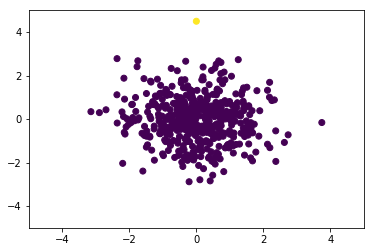

In [49]:
axes = plt.gca()
axes.set_xlim([-5,5])
axes.set_ylim([-5,5])
plt.scatter(x[:,0],x[:,1],c=y)

In [55]:
split_point = int(n_samples*0.8)
x_train, x_valid = x[:split_point], x[split_point:]
_, y_valid = y[:split_point], y[split_point:]

### Multivariate Gaussian model

In [108]:
def gauss_density(X,M,S):
    n = len(M)
    numerator = np.exp(-0.5*np.dot(np.dot((X-M).T,np.linalg.inv(S)),(X-M)))
    denominator = ((2*pi)**(n/2))*np.power(np.linalg.det(S),(1/2))
    return numerator / denominator

class Mult_Gaus(object):    
    def __init__(self,eps=2e-5):
        self.mu = None
        self.sigma = None
        self.eps = eps
        
    def fit(self, data):
        self.mu = np.mean(data,axis=0)
        self.sigma = np.cov(data.T)
        
    def forward(self, xs):
        result = np.zeros(np.shape(xs)[0])
        for i,x in enumerate(xs):
            result[i] = gauss_density(x,self.mu,self.sigma)
        result = (result < self.eps).astype(int)
        return result
    
    def evaluate(self,xs,ys):
        preds = self.forward(xs)
        return confusion_matrix(ys,preds)
        

We will start by setting epsilon value such that all the examples in training set are going to be classified as non-anomalous. Then, we will further change it to fit validation set too.

In [131]:
eps = 1e-4
model = Mult_Gaus(eps)

In [139]:
model.fit(x_train)
conf_mat = model.evaluate(x_train, np.array([0]*split_point))
conf_mat

array([[400]], dtype=int64)

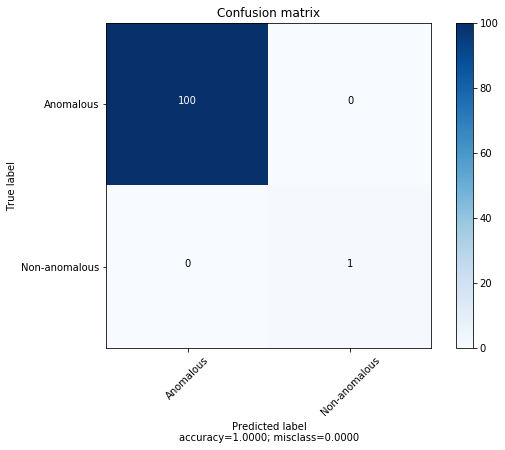

In [137]:
conf_mat = model.evaluate(x_valid, y_valid)
plot_confusion_matrix(conf_mat,['Anomalous', 'Non-anomalous'],normalize=False)